In [1]:
# Imports
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau # scheduler
from torch.optim import  Adam # optimizer
from torch.nn import CrossEntropyLoss # loss criterion
import copy


import matplotlib.pyplot as plt
torch.cuda.empty_cache()

import sys
# Add the upper directories to the path
sys.path.append("../models/")
from CustomCNNVessel import CustomResNet

sys.path.append("../data/")
from VessMapDatasetLoader import vess_map_dataloader

In [2]:
# Setting gpu
torch.cuda.empty_cache()
device = torch.device("cuda")

In [3]:
image_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/images'
mask_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/labels'
skeleton_dir = '/home/fonta42/Desktop/interpretacao-redes-neurais/data/VessMap/skeletons'

batch_size = 4
train_size = 0.7


In [4]:
image_size = 32

train_loader_32, test_loader_32 = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size,
                                  image_size = image_size)

In [5]:
image_size = 64

train_loader_64, test_loader_64 = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size,
                                  image_size = image_size)

In [7]:
image_size = 96

train_loader_96, test_loader_96 = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size,
                                  image_size = image_size)

In [8]:
image_size = 128

train_loader_128, test_loader_128 = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size,
                                  image_size = image_size)

In [9]:
image_size = 224

train_loader_224, test_loader_224 = vess_map_dataloader(image_dir, 
                                  mask_dir, 
                                  skeleton_dir, 
                                  batch_size,
                                  train_size = train_size,
                                  image_size = image_size)

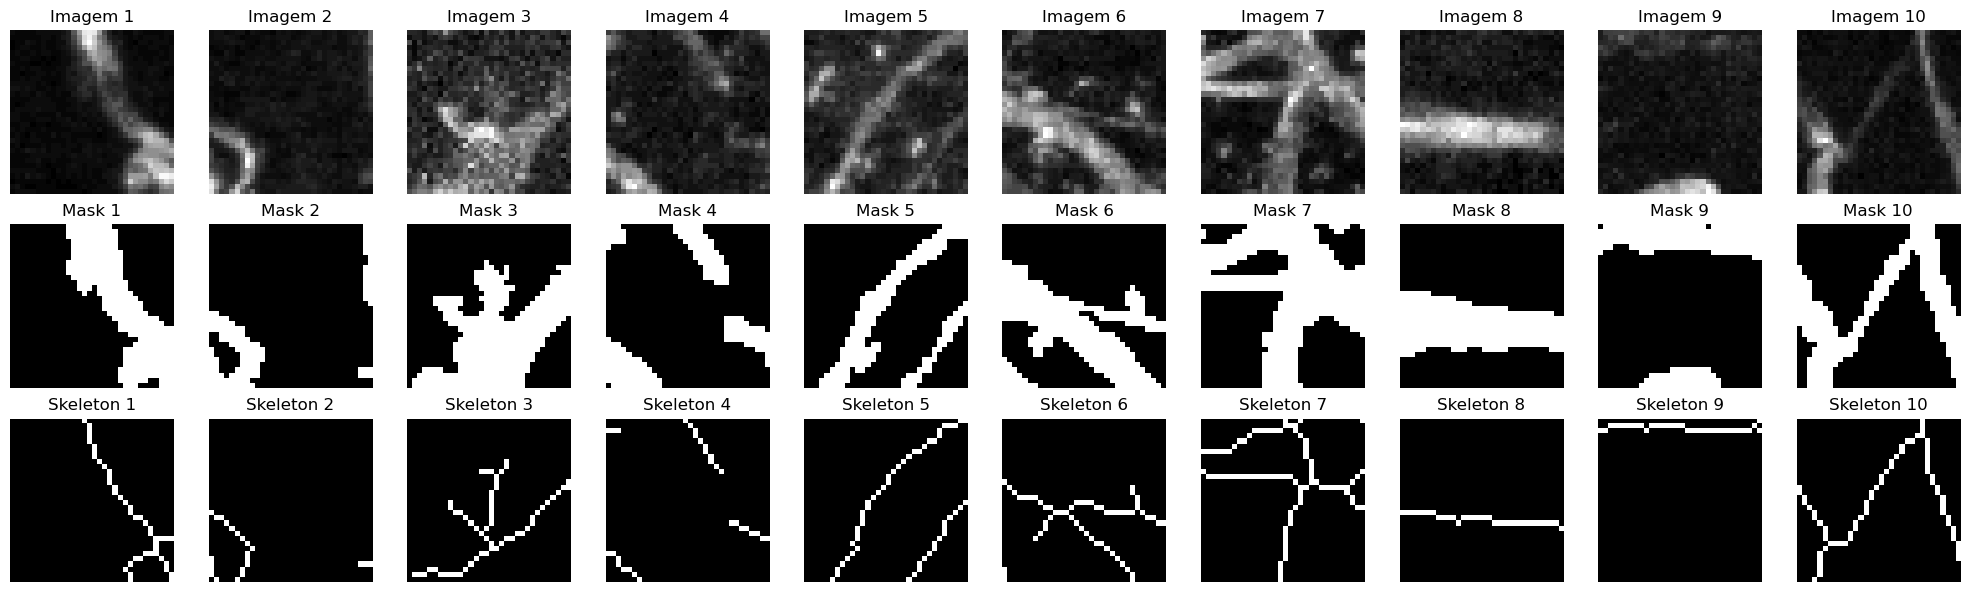

In [6]:
def show_images(data_loader, num_sets=10):
    fig, axs = plt.subplots(3, num_sets, figsize=(20, 6)) # 3 rows for images, masks, and skeletons, and num_sets columns

    # Initialize a counter for the number of sets displayed
    num_displayed = 0

    for images, masks, skeletons in data_loader:
        for i in range(images.size(0)):
            if num_displayed >= num_sets:
                break

            # Plotting image
            axs[0, num_displayed].imshow(images[i].permute(1, 2, 0), cmap='gray') # Rearrange dimensions to HWC for display
            axs[0, num_displayed].axis('off')
            axs[0, num_displayed].set_title(f'Imagem {num_displayed+1}')

            # Plotting mask
            axs[1, num_displayed].imshow(masks[i].squeeze(), cmap='gray') # Assuming mask is single-channel
            axs[1, num_displayed].axis('off')
            axs[1, num_displayed].set_title(f'Mask {num_displayed+1}')

            # Plotting skeleton
            axs[2, num_displayed].imshow(skeletons[i].squeeze(), cmap='gray') # Assuming skeleton is single-channel
            axs[2, num_displayed].axis('off')
            axs[2, num_displayed].set_title(f'Skeleton {num_displayed+1}')

            num_displayed += 1

        if num_displayed >= num_sets:
            break

    plt.tight_layout()
    plt.show()

# Call the function
show_images(train_loader_32, num_sets=10)

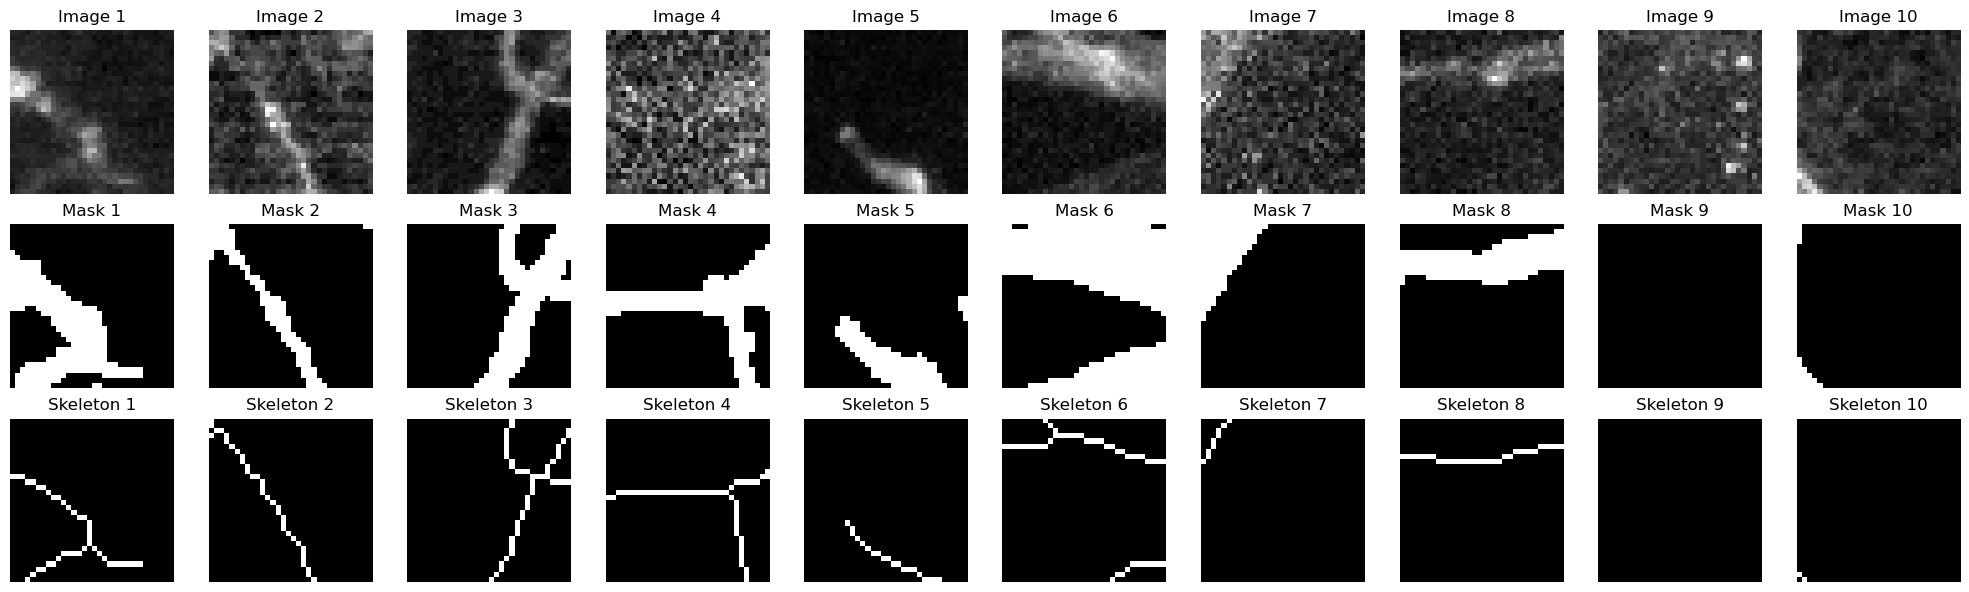

In [11]:
show_images(train_loader_32, num_sets=10)

In [7]:
# Defining IOU to use as metric
def iou_metric(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def sum_params(model, mode='l2'):
    s = 0,
              gradient_optimization = False
    for param in model.parameters():
        if mode == 'l2':
            s += (param ** 2).sum()
        else:
            s += param.abs().sum()
    return s

In [16]:
# Auxiliary Functions
def get_all_gradients(model, image, sampling_rate=1, device="cuda", vectorize=False):

    model.to(device)
    model = model.eval()
    model_wrapped = wrapper(model)
    sampled_image = image[:,::sampling_rate,::sampling_rate]
    sampled_image = sampled_image.to(device).unsqueeze(0)
    sampled_image.requires_grad = True

    jacobian = torch.autograd.functional.jacobian(model_wrapped, 
                                                            sampled_image,
                                                            vectorize = vectorize)
    jacobian = jacobian.squeeze().to('cpu')
    return jacobian

def wrapper(model):
    '''Wrap model to return probabilities and only the vessel channel.'''
    def new_model(img):
        out = model(img)
        probs = F.softmax(out, dim=1)
        return probs[:,1]
    return new_model


def jacobian_activation(jacobian_gradient):  
    dimension = jacobian_gradient.shape[0]
    map = jacobian_gradient.permute(2, 3, 0, 1).reshape(dimension, dimension, dimension*dimension).cuda()
    #avg_activation = torch.mean(map, dim=2).values
    max_activation = torch.max(map, dim=2).values
    
    return max_activation

def plot_metrics(train_losses, test_losses, train_ious, test_ious, optimization_epochs=0, title=''):
    plt.figure(figsize=(8, 6))

    # Subplot 1: Losses
    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(train_losses, label='Perda de treino', color='blue')
    ax1.plot(test_losses, label='Perda de teste', color='red')
    if optimization_epochs > 0:  # Plot scatter at every optimization_epochs
        ax1.scatter(range(optimization_epochs, len(train_losses), optimization_epochs), [train_losses[i] for i in range(optimization_epochs, len(train_losses), optimization_epochs)], color='blue')
        ax1.scatter(range(optimization_epochs, len(test_losses), optimization_epochs), [test_losses[i] for i in range(optimization_epochs, len(test_losses), optimization_epochs)], color='red')
    ax1.set_title('Treino vs Teste Perdas' + title)
    ax1.set_xlabel('Épocas')
    ax1.set_ylabel('Perdas')
    ax1.legend()

    # Subplot 2: IoUs
    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(train_ious, label='IoU de treino', color='green')
    ax2.plot(test_ious, label='IoU de teste', color='purple')
    if optimization_epochs > 0:  # Plot scatter at every optimization_epochs
        ax2.scatter(range(optimization_epochs, len(train_ious), optimization_epochs), [train_ious[i] for i in range(optimization_epochs, len(train_ious), optimization_epochs)], color='green')
        ax2.scatter(range(optimization_epochs, len(test_ious), optimization_epochs), [test_ious[i] for i in range(optimization_epochs, len(test_ious), optimization_epochs)], color='purple')
    ax2.set_title('Treino vs Teste IoU' + title)
    ax2.set_xlabel('Época')
    ax2.set_ylabel('IoU')
    ax2.legend()

    plt.tight_layout()
    plt.savefig('/home/fonta42/Desktop/imagens-ic-relatorio-final/train_analysis.pdf', format='pdf')

    plt.show()


In [10]:
def training_loop(
    model,
    train_loader,
    test_loader,
    num_epochs,
    train_losses,
    test_losses,
    train_ious,
    test_ious,
    model_path='',
    lr=1e-4,
    weight_decay=1e-4,
    save_epochs = 0,
    save_models = False,
    model_name = '',
):
    optimizer = Adam(params=model.parameters(), 
                     lr=lr, 
                     weight_decay=weight_decay)
    
    scheduler = ReduceLROnPlateau(optimizer=optimizer, 
                                  mode="min", 
                                  patience=10, 
                                  factor=0.75)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        model.train()
        running_loss = 0.0
        train_iou = 0.0
        for i, data in enumerate(train_loader):
            inputs, labels, _ = data
            inputs, labels = inputs.cuda(), labels.cuda().squeeze(1).long()
            
            outputs = model(inputs)
            criterion = CrossEntropyLoss()
            loss = criterion(outputs, labels)
            loss.backward()
            running_loss += loss.detach()

            optimizer.step()
        
        avg_train_loss = running_loss.item() / len(train_loader)
        train_losses.append(avg_train_loss)
        _, predicted = torch.max(outputs.data, 1)
        train_iou += iou_metric(labels.float(), predicted.float())
        train_ious.append(train_iou.cpu())
        
        model.eval()
        test_loss = 0.0
        total_iou = 0.0
        with torch.no_grad():
            for data in test_loader:
                images, labels, _ = data
                images, labels = images.cuda(), labels.cuda()
                labels = labels.squeeze(1).long()
                outputs = model(images)
                loss = criterion(outputs, labels).mean()
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_iou += iou_metric(labels.float(), predicted.float())

        test_loss = test_loss / len(test_loader)
        test_losses.append(test_loss)
        
        test_iou = total_iou / len(test_loader)
        test_ious.append(test_iou.cpu())

        scheduler.step(test_loss)
        if lr != optimizer.param_groups[0]['lr']:
            lr = optimizer.param_groups[0]['lr']
            print("Current learning rate:", optimizer.param_groups[0]['lr'])


        print(
            f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} Test Loss: {test_loss:.4f} Train IoU: {train_iou:.4f} Test IoU: {test_iou:.4f}"
        )

        save_epochs = num_epochs if save_epochs == 0 else save_epochs
        if save_models and (epoch + 1) % save_epochs == 0:
            # Save model every 5 epochs
            torch.save(
                model.state_dict(),
                model_path
                + f"{model_name}_model_epoch_{epoch+1}_trainIoU_{train_iou:.2f}_testIoU{test_iou:.2f}_.pt",
            )

Epoch [1/100] Train Loss: 0.5560 Test Loss: 0.6255 Train IoU: 0.2340 Test IoU: 0.0209
Epoch [2/100] Train Loss: 0.4212 Test Loss: 0.9427 Train IoU: 0.1059 Test IoU: 0.0302
Epoch [3/100] Train Loss: 0.4333 Test Loss: 1.3169 Train IoU: 0.6325 Test IoU: 0.1179
Epoch [4/100] Train Loss: 0.4701 Test Loss: 0.5575 Train IoU: 0.1826 Test IoU: 0.3279
Epoch [5/100] Train Loss: 0.4120 Test Loss: 0.4669 Train IoU: 0.4705 Test IoU: 0.4570
Epoch [6/100] Train Loss: 0.4288 Test Loss: 0.4680 Train IoU: 0.4274 Test IoU: 0.4022
Epoch [7/100] Train Loss: 0.4181 Test Loss: 0.5406 Train IoU: 0.5762 Test IoU: 0.4913
Epoch [8/100] Train Loss: 0.4547 Test Loss: 0.6518 Train IoU: 0.7463 Test IoU: 0.2901
Epoch [9/100] Train Loss: 0.4116 Test Loss: 0.6289 Train IoU: 0.5272 Test IoU: 0.3962
Epoch [10/100] Train Loss: 0.4076 Test Loss: 0.5356 Train IoU: 0.3924 Test IoU: 0.2322
Epoch [11/100] Train Loss: 0.3628 Test Loss: 0.3624 Train IoU: 0.3855 Test IoU: 0.5055
Epoch [12/100] Train Loss: 0.3575 Test Loss: 0.4449 

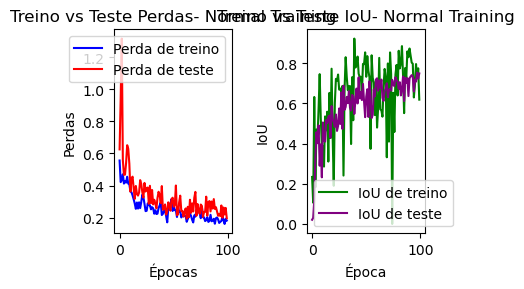

<Figure size 640x480 with 0 Axes>

In [13]:
# 32x32
normal_train_losses_32 = []
normal_test_losses_32 = []
normal_train_ious_32 = []
normal_test_ious_32 = []

num_epochs = 100

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 
training_loop(model, 
              train_loader_32, 
              test_loader_32, 
              num_epochs, 
              normal_train_losses_32, 
              normal_test_losses_32, 
              normal_train_ious_32, 
              normal_test_ious_32,
              lr=1e-4,
              weight_decay=1e-4,
              model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/normal_vessels/")

plot_metrics(normal_train_losses_32, 
             normal_test_losses_32, 
             normal_train_ious_32,
             normal_test_ious_32,
             title='- Normal Training')

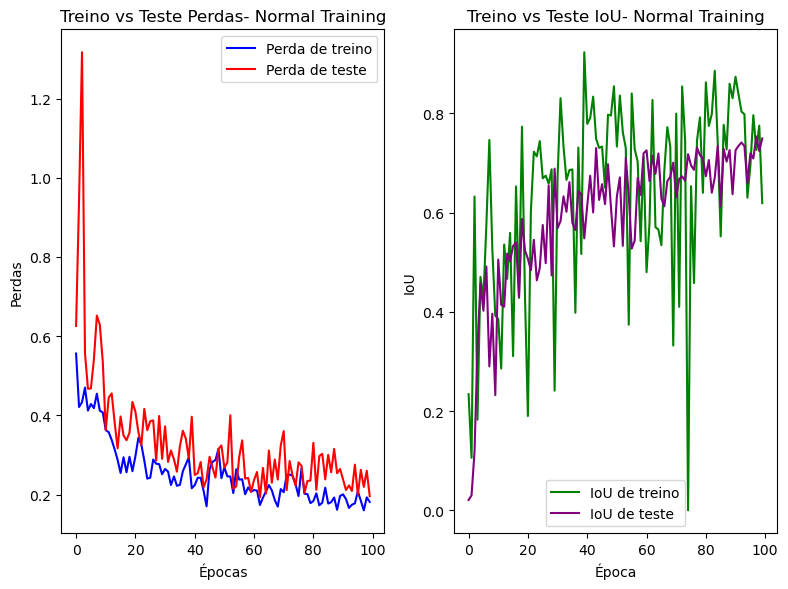

In [17]:
plot_metrics(normal_train_losses_32, 
             normal_test_losses_32, 
             normal_train_ious_32,
             normal_test_ious_32,
             title='- Normal Training')

In [16]:
""" # Gradient optimization model training
# Placeholders for metrics
train_losses_32 = []
test_losses_32 = []
train_ious_32 = []
test_ious_32 = []

num_epochs = 59

# Model Initialization
grad_model = CustomResNet(num_classes=2).cuda() 
training_loop(grad_model, 
              train_loader_32, 
              train_loader_32, 
              num_epochs, 
              train_losses_32, 
              test_losses_32, 
              train_ious_32, 
              test_ious_32,
              lr=1e-4,
              weight_decay=1e-4,
              model_path= "/home/fonta42/Desktop/interpretacao-redes-neurais/models/gradient_optimization_vessels/",
              gradient_optimization = True,
              optim_idx = 10) """

' # Gradient optimization model training\n# Placeholders for metrics\ntrain_losses_32 = []\ntest_losses_32 = []\ntrain_ious_32 = []\ntest_ious_32 = []\n\nnum_epochs = 59\n\n# Model Initialization\ngrad_model = CustomResNet(num_classes=2).cuda() \ntraining_loop(grad_model, \n              train_loader_32, \n              train_loader_32, \n              num_epochs, \n              train_losses_32, \n              test_losses_32, \n              train_ious_32, \n              test_ious_32,\n              lr=1e-4,\n              weight_decay=1e-4,\n              model_path= "/home/fonta42/Desktop/interpretacao-redes-neurais/models/gradient_optimization_vessels/",\n              gradient_optimization = True,\n              optim_idx = 10) '

In [17]:
""" plot_metrics(train_losses_32, 
             test_losses_32, 
             train_ious_32,
             test_ious_32,
             title='- Gradient Optimization Training',
             optimization_epochs=10) """

" plot_metrics(train_losses_32, \n             test_losses_32, \n             train_ious_32,\n             test_ious_32,\n             title='- Gradient Optimization Training',\n             optimization_epochs=10) "

In [31]:
import torchseg

unet_restnet_model = torchseg.Unet(
    encoder_name="resnet18",
    encoder_weights=True,
    in_channels=1,
    classes=2,
).to(device)

#unet_restnet_model

Epoch [1/250] Train Loss: 0.8010 Test Loss: 1.0804 Train IoU: 0.3763 Test IoU: 0.2322
Epoch [2/250] Train Loss: 0.5297 Test Loss: 0.4693 Train IoU: 0.5486 Test IoU: 0.4055
Epoch [3/250] Train Loss: 0.4269 Test Loss: 0.4061 Train IoU: 0.6887 Test IoU: 0.4756
Epoch [4/250] Train Loss: 0.3644 Test Loss: 0.3254 Train IoU: 0.7173 Test IoU: 0.5322
Epoch [5/250] Train Loss: 0.3202 Test Loss: 0.3471 Train IoU: 0.3311 Test IoU: 0.5724
Epoch [6/250] Train Loss: 0.3005 Test Loss: 0.2756 Train IoU: 0.3927 Test IoU: 0.6205
Epoch [7/250] Train Loss: 0.3001 Test Loss: 0.3690 Train IoU: 0.7439 Test IoU: 0.5249
Epoch [8/250] Train Loss: 0.3000 Test Loss: 0.2535 Train IoU: 0.6842 Test IoU: 0.6308
Epoch [9/250] Train Loss: 0.2921 Test Loss: 0.2710 Train IoU: 0.4655 Test IoU: 0.6357
Epoch [10/250] Train Loss: 0.2681 Test Loss: 0.2360 Train IoU: 0.6640 Test IoU: 0.6792
Epoch [11/250] Train Loss: 0.2471 Test Loss: 0.2046 Train IoU: 0.5886 Test IoU: 0.6685
Epoch [12/250] Train Loss: 0.2286 Test Loss: 0.2254 

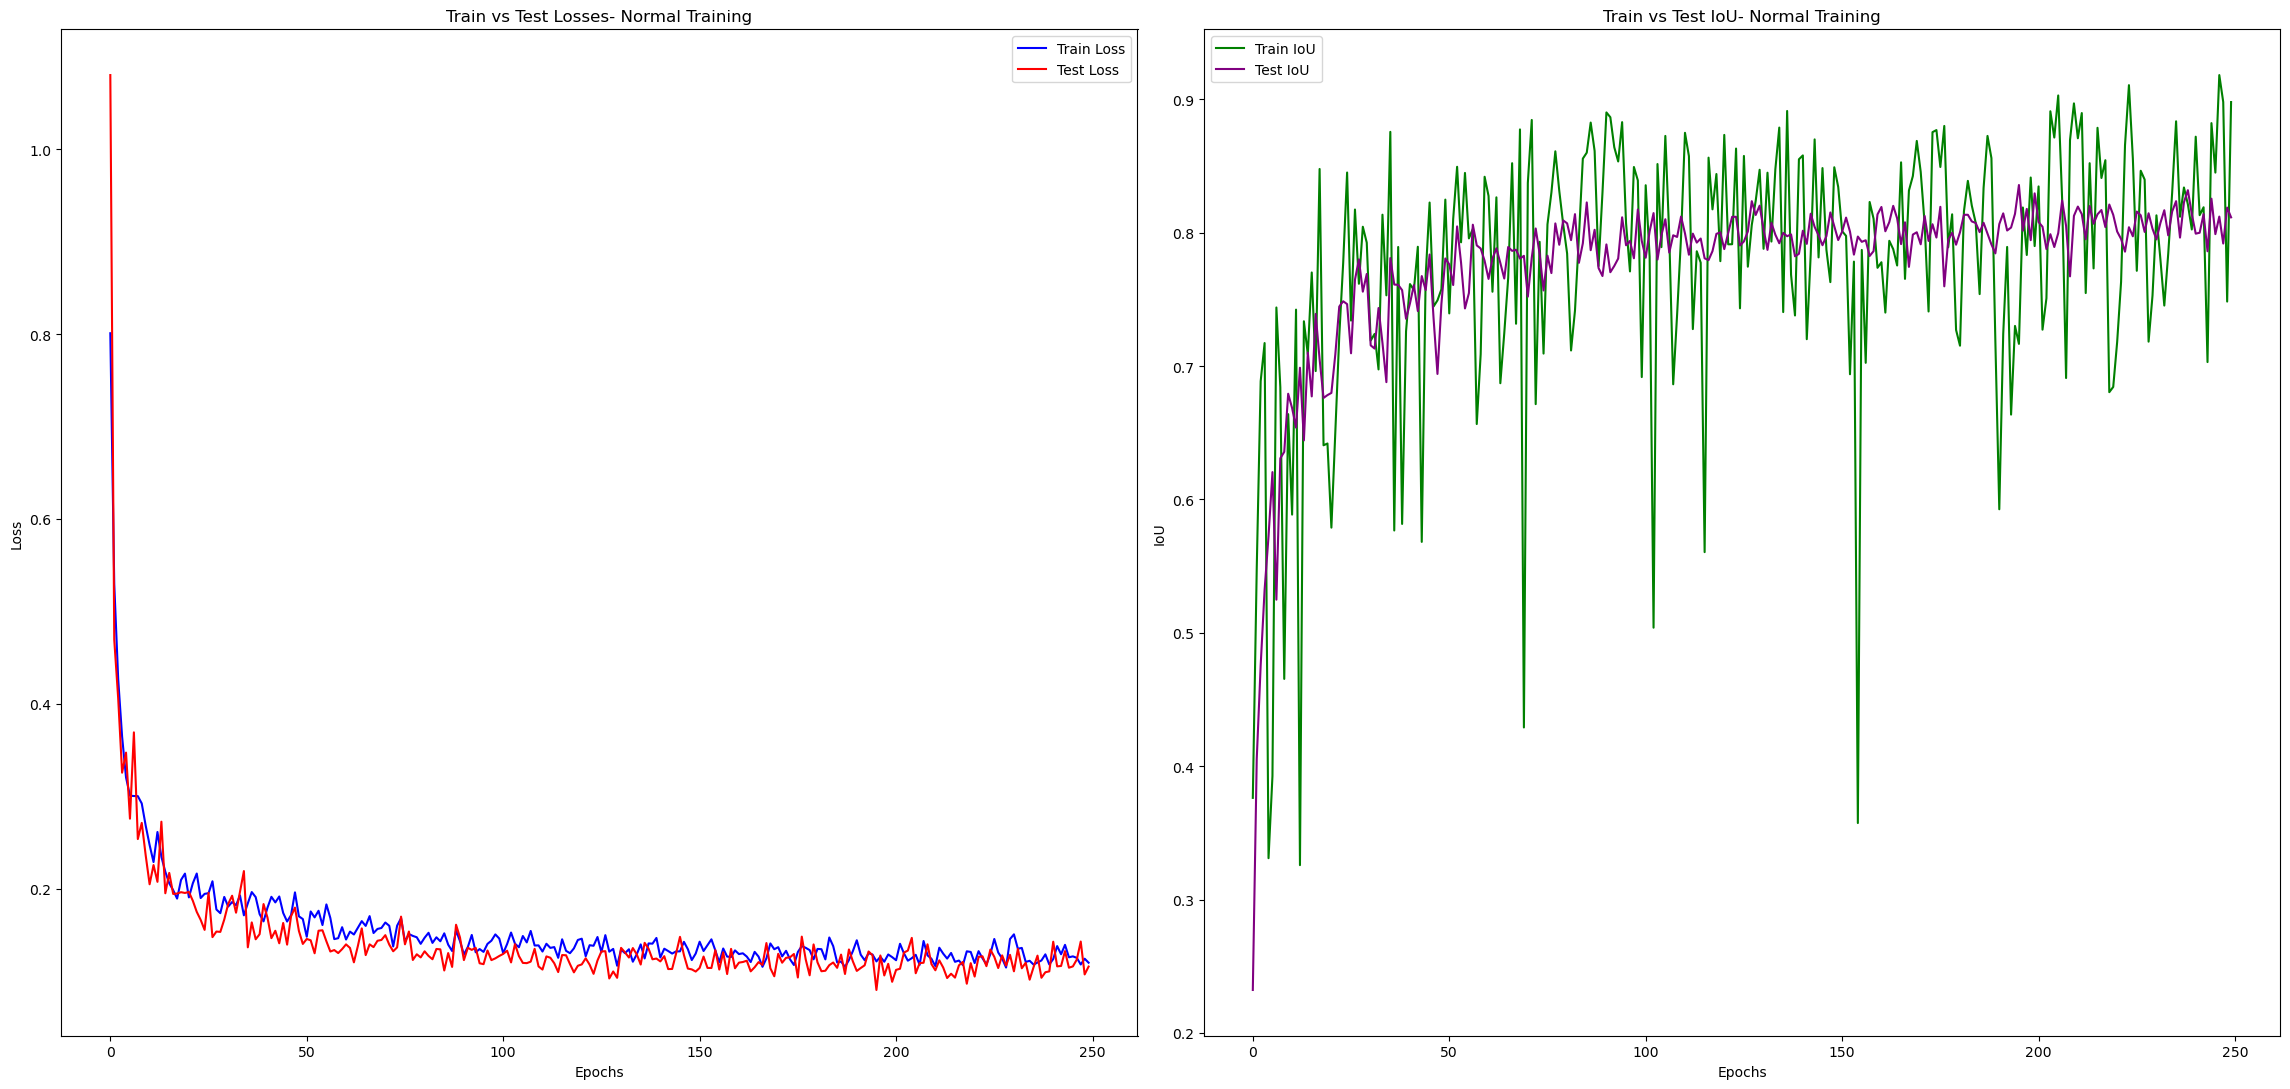

In [32]:
# 64x64
normal_train_losses_64 = []
normal_test_losses_64 = []
normal_train_ious_64 = []
normal_test_ious_64 = []

num_epochs = 250

training_loop(unet_restnet_model, 
              train_loader_64, 
              test_loader_64, 
              num_epochs, 
              normal_train_losses_64, 
              normal_test_losses_64,
              normal_train_ious_64, 
              normal_test_ious_64,
              lr=2e-4,
              weight_decay=1e-4,
              gradient_optimization = False)


plot_metrics(normal_train_losses_64, 
             normal_test_losses_64,
             normal_train_ious_64,
             normal_test_ious_64,
             title='- Normal Training')

model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/torchseg/pretrained_unet_resnet.pt"
torch.save(unet_restnet_model.state_dict(), model_path)

Epoch [1/250] Train Loss: 0.5779 Test Loss: 0.5867 Train IoU: 0.5124 Test IoU: 0.3087
Epoch [2/250] Train Loss: 0.4058 Test Loss: 0.4609 Train IoU: 0.5776 Test IoU: 0.1412
Epoch [3/250] Train Loss: 0.3354 Test Loss: 0.3262 Train IoU: 0.6135 Test IoU: 0.4290
Epoch [4/250] Train Loss: 0.2969 Test Loss: 0.3144 Train IoU: 0.4756 Test IoU: 0.5335
Epoch [5/250] Train Loss: 0.3074 Test Loss: 0.3083 Train IoU: 0.5834 Test IoU: 0.4674
Epoch [6/250] Train Loss: 0.3003 Test Loss: 0.2963 Train IoU: 0.5554 Test IoU: 0.5700
Epoch [7/250] Train Loss: 0.2678 Test Loss: 0.2593 Train IoU: 0.6650 Test IoU: 0.6157
Epoch [8/250] Train Loss: 0.2720 Test Loss: 0.2714 Train IoU: 0.5880 Test IoU: 0.6049
Epoch [9/250] Train Loss: 0.2601 Test Loss: 0.2427 Train IoU: 0.6884 Test IoU: 0.6669
Epoch [10/250] Train Loss: 0.2291 Test Loss: 0.2068 Train IoU: 0.6649 Test IoU: 0.6501
Epoch [11/250] Train Loss: 0.2129 Test Loss: 0.2098 Train IoU: 0.6836 Test IoU: 0.6325
Epoch [12/250] Train Loss: 0.2580 Test Loss: 0.2038 

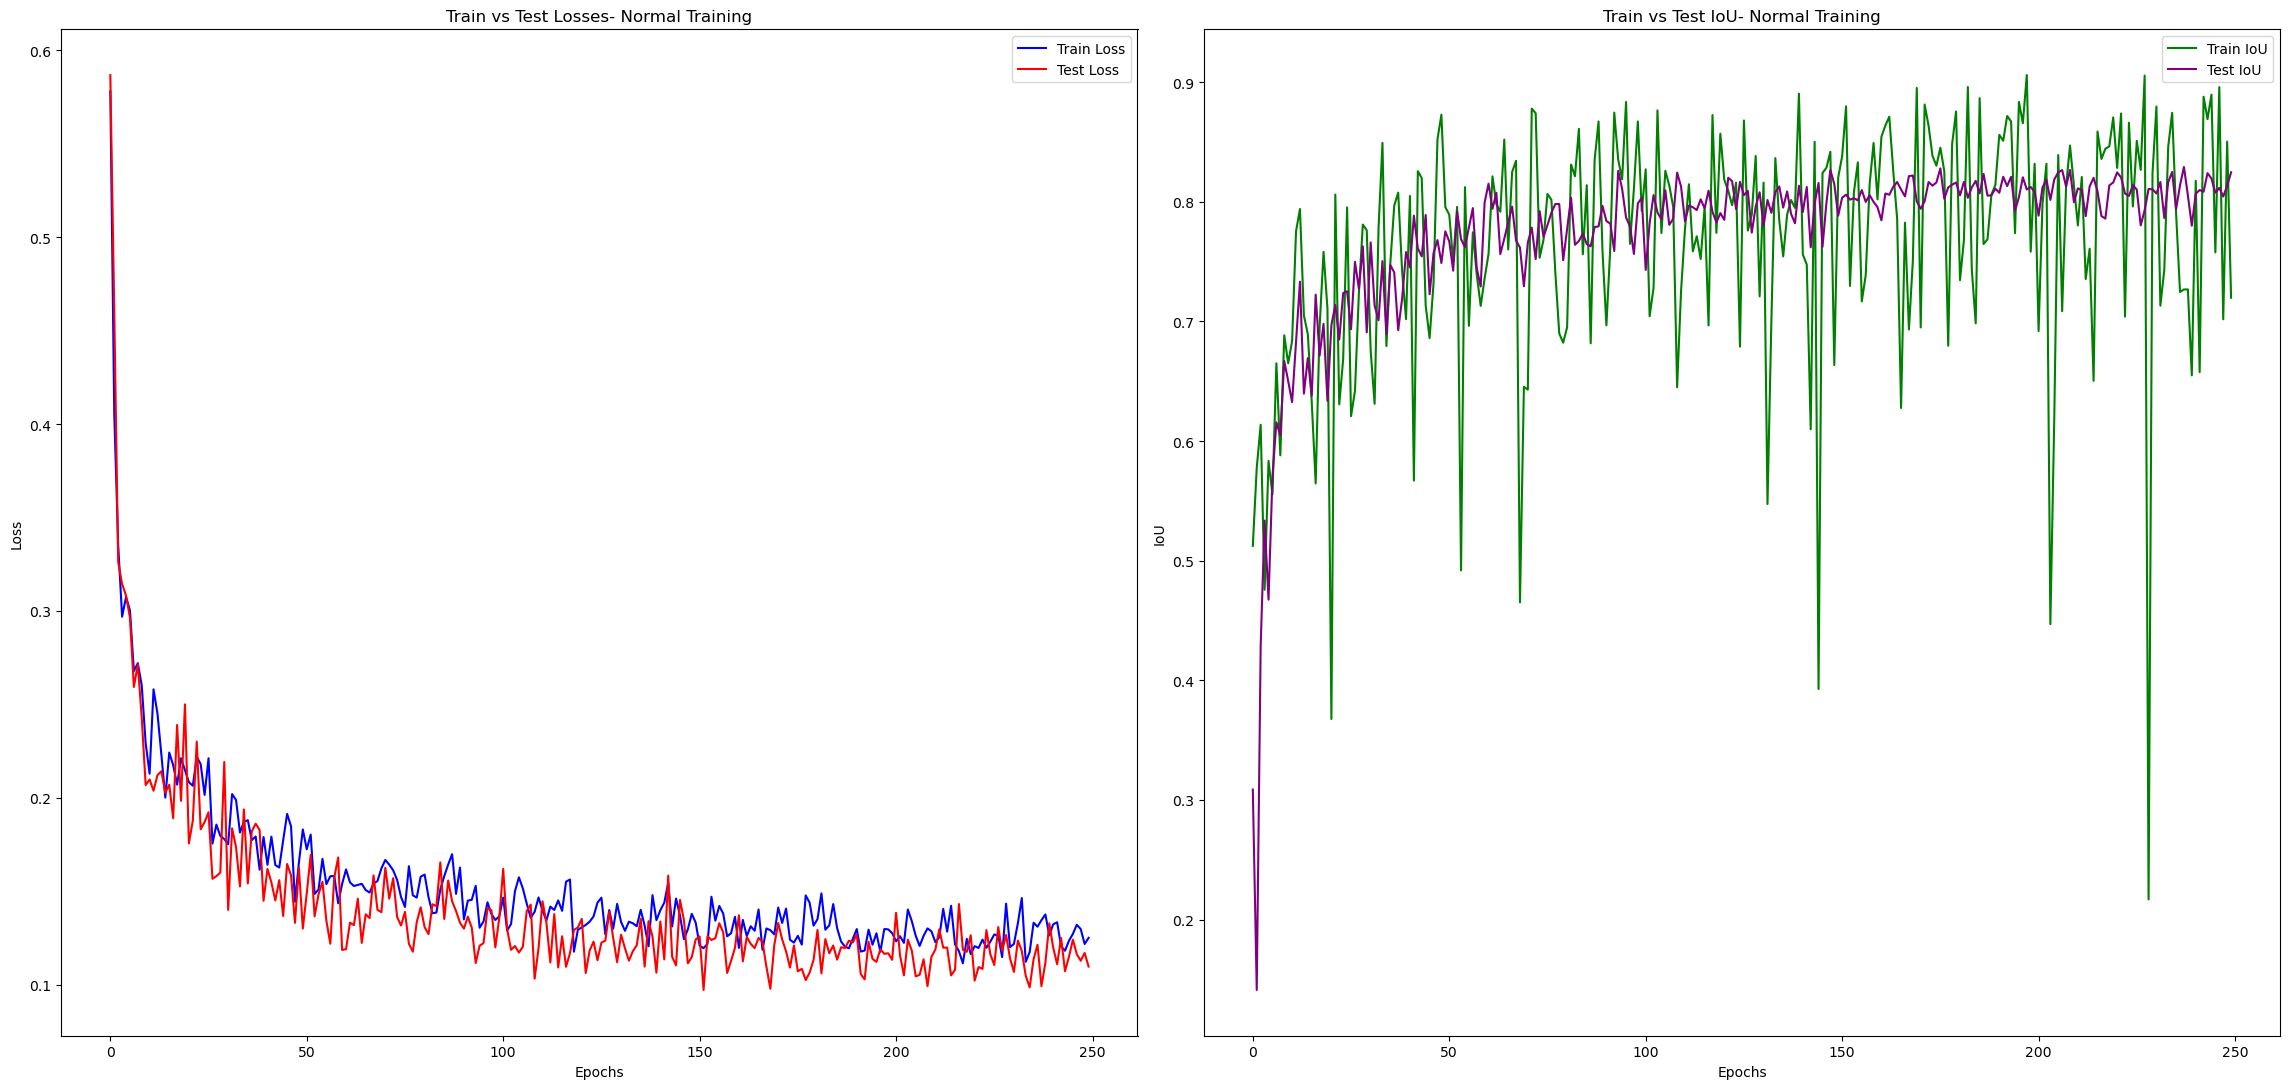

In [33]:
unet_restnet_model = torchseg.Unet(
    encoder_name="resnet18",
    encoder_weights=False,
    in_channels=1,
    classes=2,
).to(device)

# 64x64
normal_train_losses_64 = []
normal_test_losses_64 = []
normal_train_ious_64 = []
normal_test_ious_64 = []

num_epochs = 250

training_loop(unet_restnet_model, 
              train_loader_64, 
              test_loader_64, 
              num_epochs, 
              normal_train_losses_64, 
              normal_test_losses_64,
              normal_train_ious_64, 
              normal_test_ious_64,
              lr=2e-4,
              weight_decay=1e-4,
              gradient_optimization = False)


plot_metrics(normal_train_losses_64, 
             normal_test_losses_64,
             normal_train_ious_64,
             normal_test_ious_64,
             title='- Normal Training')

model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/torchseg/unet_resnet.pt"
torch.save(unet_restnet_model.state_dict(), model_path)

In [ ]:
# 64x64
normal_train_losses_64 = []
normal_test_losses_64 = []
normal_train_ious_64 = []
normal_test_ious_64 = []

num_epochs = 59

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 
training_loop(model, 
              train_loader_64, 
              test_loader_64, 
              num_epochs, 
              normal_train_losses_64, 
              normal_test_losses_64,
              normal_train_ious_64, 
              normal_test_ious_64,
              lr=2e-4,
              weight_decay=1e-4,
              model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/normal_vessels/",
              gradient_optimization = False)


plot_metrics(normal_train_losses_64, 
             normal_test_losses_64,
             normal_train_ious_64,
             normal_test_ious_64,
             title='- Normal Training')

In [ ]:
# 64x64
train_losses_64 = []
test_losses_64 = []
train_ious_64 = []
test_ious_64 = []

num_epochs = 59

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 
training_loop(model, 
              train_loader_64, 
              test_loader_64, 
              num_epochs, 
              train_losses_64, 
              test_losses_64, 
              train_ious_64, 
              test_ious_64,
              lr=2e-4,
              weight_decay=1e-4,
              model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/vessels/",
              gradient_optimization = True,
              optim_idx = 10)


plot_metrics(train_losses_64, 
             test_losses_64,
             train_ious_64,
             test_ious_64,
             title='- Normal Training')

In [ ]:
# 96x96
torch.cuda.empty_cache()


# Normal model training 
# Placeholders for metrics
normal_train_losses = []
normal_test_losses = []
normal_train_ious = []
normal_test_ious = []

num_epochs = 100

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 
training_loop(model, 
              train_loader_96, 
              test_loader_96, 
              num_epochs, 
              normal_train_losses, 
              normal_test_losses, 
              normal_train_ious, 
              normal_test_ious,
              lr=2e-4,
              weight_decay=1e-4,
              model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/normal_vessels/",
              gradient_optimization = False)


plot_metrics(normal_train_losses, 
             normal_test_losses, 
             normal_train_ious,
             normal_test_ious,
             title='- Normal Training')

In [ ]:
# 128x128

torch.cuda.empty_cache()


# Normal model training 
# Placeholders for metrics
normal_train_losses = []
normal_test_losses = []
normal_train_ious = []
normal_test_ious = []

num_epochs = 100

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 
training_loop(model, 
              train_loader_128, 
              test_loader_128, 
              num_epochs, 
              normal_train_losses, 
              normal_test_losses, 
              normal_train_ious, 
              normal_test_ious,
              lr=2e-4,
              weight_decay=1e-4,
              model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/normal_vessels/",
              gradient_optimization = False)


plot_metrics(normal_train_losses, 
             normal_test_losses, 
             normal_train_ious,
             normal_test_ious,
             title='- Normal Training')

In [ ]:
# 224 x 224

torch.cuda.empty_cache()


# Normal model training 
# Placeholders for metrics
normal_train_losses = []
normal_test_losses = []
normal_train_ious = []
normal_test_ious = []

num_epochs = 100

# Model Initialization
model = CustomResNet(num_classes=2).cuda() 
training_loop(model, 
              train_loader_224, 
              test_loader_224, 
              num_epochs, 
              normal_train_losses, 
              normal_test_losses, 
              normal_train_ious, 
              normal_test_ious,
              lr=2e-4,
              weight_decay=1e-4,
              model_path = "/home/fonta42/Desktop/interpretacao-redes-neurais/models/normal_vessels/",
              gradient_optimization = False)


plot_metrics(normal_train_losses, 
             normal_test_losses, 
             normal_train_ious,
             normal_test_ious,
             title='- Normal Training')